In [26]:
# import the necessary packages

import cv2
import time
import sys
import os
import math as mt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Import utilites
from utils import label_map_util
from utils import visualization_utils as vis_util


In [27]:
# slideing the window
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])


# getting the padding information
def getpad(n,m,o):
    p = mt.ceil((n-(m*o))/(m*(1-o)))
    nn = mt.floor(m*p-((p-1)*(m*o)))
    return nn-n

# calculate total numeber of Iterations
def total(n,l,m,o):
    p = mt.ceil((n-(m*o))/(m*(1-o)))
    a=mt.ceil((n-p*m*o)/m)
    p = mt.ceil((l-(m*o))/(m*(1-o)))
    b=mt.ceil((l-p*m*o)/m)
    return a*b

In [28]:
# Name of the directory containing the object detection module we're using
MODEL_NAME = 'inference_graph'
MODEL_NAME = 'inference_graph'


# Grab path to current working directory
CWD_PATH = os.getcwd()

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,'frozen_inference_graph.pb')

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,'training','labelmap.pbtxt')


# Number of classes the object detector can identify
NUM_CLASSES = 1

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# Input Section

In [29]:
#................................................................................
#................................................................................
#.......................... INPUT SECTION .......................................
#................................................................................
#................................................................................


# feed the valus of box size and overlap percentage
ovlap=5/100


# feed the spatial resolution of input image
sr=7.5

filename="1.jpg"
image = cv2.imread(filename)

"""
here are the names of some samples that are included in the folder.
The spatial resolution also mentioned in the image name itself.

Don't forget to change the spatial resolution (sr) before running the code.


1. Arlington_30.5cm.tif
2. Atlanta_15cm.tif
3. Christchurch_7.5cm.jpg
4. DC_16cm.jpg
5. NewYork_15cm.tif
6. Norfolk_30cm.tif
7. trained_12.5.jpg

"""






# force resize the image
#image = cv2.resize(image,(1000,1000))



box=int(256*(12.5/sr))

#Force a box size
#box=300

#................................................................................
#................................................................................
#................................................................................
#................................................................................
#................................................................................


Box Size: 426
steps 404
Row resolution: 1583 >> 1852 
Col resolution: 1775 >> 1832 
Total Iteration: 25


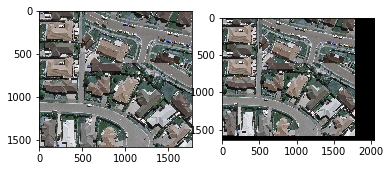

Progress: 
.........................
....................Done


In [30]:


print("Box Size:",box)

original= image.copy()

(winW, winH) = (box, box)

a=int(image.shape[0])
b=int(image.shape[1])

stepS=mt.floor(box*(1-ovlap))
print("steps",stepS)

x=np.transpose(original)

#pass image length, box length, and overlap percentage
row=getpad(b,box,ovlap)
col=getpad(a,box,ovlap)
total=total(row+a,col+b,box,ovlap)
print("Row resolution:",a,">>",row+a,"\nCol resolution:",b,">>",col+b,"\nTotal Iteration:",total)

# initializations
it=0
xx=True


image1=np.lib.pad(x, [(0,0),(0,row),(0,col)], 'constant')

image=np.transpose(image1)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(original)
fig.add_subplot(1,2,2)
plt.imshow(image)
plt.show()



for (x, y, window) in sliding_window(image, stepSize=stepS, windowSize=(winH, winW)):
    
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
        continue    

    # Load image using OpenCV and
    # expand image dimensions to have shape: [1, None, None, 3]
    # i.e. a single-column array, where each item in the column has the pixel RGB value
    image_expanded = np.expand_dims(window, axis=0)

    
    # Perform the actual detection by running the model with the image as input
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_expanded})

    
    # Draw the results of the detection (aka 'visulaize the results')
    vis_util.visualize_boxes_and_labels_on_image_array(
        window,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=5,
        min_score_thresh=0.8)

    
    
    # terminating the process
    if (cv2.waitKey(1)==ord("q")):
        print("aboart")
        break

    # we'll just draw the window
    clone = image.copy()
    cv2.rectangle(clone, (x, y), (x + winH, y + winW), (0, 0, 255), 5)
    cv2.imshow("Window", clone)
    cv2.waitKey(1)
    time.sleep(1.425)
    it=it+1
    
    # process visualization 
    if xx==True:
        aa="."
        print("Progress: \n"+str(aa*total))
        xx=False
        
    # process status indicator
    print(".",end="")
    
        

# process completion alert        
print("Done")

# saving the result
result="results/Result__"+str(filename)
cv2.imwrite(result,clone);

# adding viewing time
time.sleep(5)

# closing the window
cv2.destroyWindow("Window")